## MACD with Python

Default setting s for MACD indicator in tradingview.com are Fast length = 12
Slow length = 26
Signal smoothing = 9

Buy sell signals are generated when MACD line crosses the signal line.

In addition to this we have also the histogram that servers as an early warning for crossovers. When bars are getting shorter, it signals that crossover signal might come soon.

Bullish market -  when both lines are above zero, crossover is sell signal
Bearish market - when both lines are below zero, crossover is buy signal

And the crossover might signify the reversal of a trend.


In [1317]:
#optional installations: 
#!pip install yfinance --upgrade --no-cache-dir
#!pip3 install pandas_datareader


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline

In [1318]:
# ___variables___
ticker = 'AAPL'
#ticker = 'TSLA'
#ticker = 'GOOGL'
ticker = 'BIDU'
ticker = 'GILD'
ticker = 'AMZN'

start_time = datetime.datetime(2017, 1, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

In [1319]:
# yahoo gives only daily historical data
connected = False
while not connected:
    try:
        ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   

# use numerical integer index instead of date    
ticker_df = ticker_df.reset_index()
print(ticker_df.head(5))

connected to yahoo
        Date        High         Low        Open       Close   Volume   Adj Close
0 2017-01-03  758.760010  747.700012  757.919983  753.669983  3521100  753.669983
1 2017-01-04  759.679993  754.200012  758.390015  757.179993  2510500  757.179993
2 2017-01-05  782.400024  760.260010  761.549988  780.450012  5830100  780.450012
3 2017-01-06  799.440002  778.479980  782.359985  795.989990  5986200  795.989990
4 2017-01-09  801.770020  791.770020  798.000000  796.919983  3446100  796.919983


In [1320]:
df = ticker_df

In [1321]:
def computeMACD (df, n_fast, n_slow, n_smooth):
    data = df['Adj Close']
    
    fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
    slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = pd.Series(fastEMA-slowEMA, name = 'MACD')
    MACDsig = pd.Series(MACD.ewm(span=n_smooth, min_periods=n_smooth).mean(), name='MACDsig')
    MACDhist = pd.Series(MACD - MACDsig, name = 'MACDhist')
    df = df.join(MACD)
    df = df.join(MACDsig)
    df = df.join(MACDhist)
    
    return df

In [1322]:
df = computeMACD(df, 12, 26, 9)

In [1323]:
print(df.head())
print(df.tail())

        Date        High         Low        Open       Close   Volume   Adj Close  MACD  MACDsig  MACDhist
0 2017-01-03  758.760010  747.700012  757.919983  753.669983  3521100  753.669983   NaN      NaN       NaN
1 2017-01-04  759.679993  754.200012  758.390015  757.179993  2510500  757.179993   NaN      NaN       NaN
2 2017-01-05  782.400024  760.260010  761.549988  780.450012  5830100  780.450012   NaN      NaN       NaN
3 2017-01-06  799.440002  778.479980  782.359985  795.989990  5986200  795.989990   NaN      NaN       NaN
4 2017-01-09  801.770020  791.770020  798.000000  796.919983  3446100  796.919983   NaN      NaN       NaN
          Date         High          Low         Open        Close   Volume    Adj Close       MACD    MACDsig   MACDhist
948 2020-10-08  3233.290039  3174.989990  3224.989990  3190.550049  3174100  3190.550049  -3.954977 -17.329499  13.374523
949 2020-10-09  3288.989990  3197.830078  3210.000000  3286.649902  4907900  3286.649902   7.155583 -12.432483  19

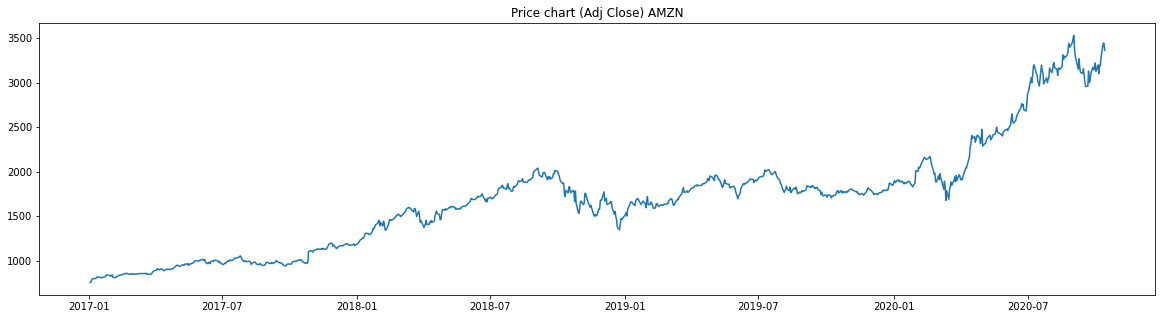

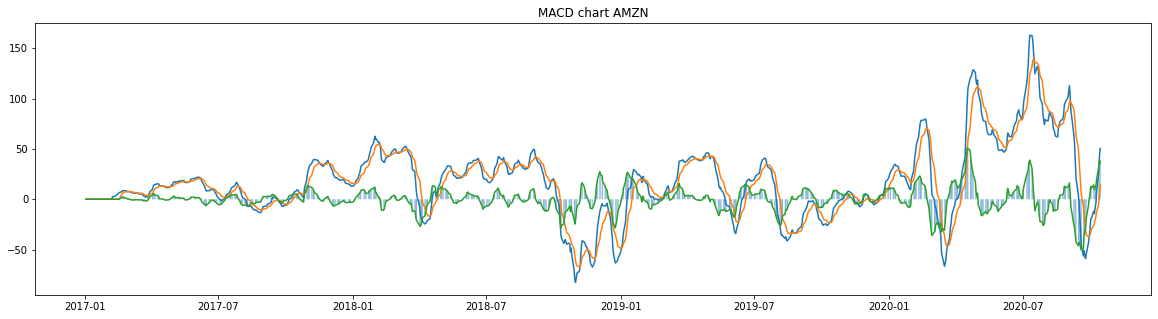

In [1324]:
# plot price
plt.figure(figsize=(20,5))
plt.plot(df['Date'], df['Adj Close'])
plt.title('Price chart (Adj Close) ' + str(ticker))
plt.show()

# plot correspondingRSI values and significant levels
plt.figure(figsize=(20,5))
plt.title('MACD chart ' + str(ticker))
plt.plot(df['Date'], df['MACD'].fillna(0))
plt.plot(df['Date'], df['MACDsig'].fillna(0))
plt.plot(df['Date'], df['MACDhist'].fillna(0))
plt.bar(df['Date'], df['MACDhist'].fillna(0), width=0.5, snap=False)

plt.show()

In [1325]:
#SIGNALS TAKEN FROM 
#https://www.youtube.com/watch?v=kz_NJERCgm8&t=493s&ab_channel=ComputerScience
#MODIFY THIS CELL

def buy_sell(signal):
    Buy = []
    Sell = []
    flag = -1
    
    for i in range(0,len(signal)):
        if signal['MACD'][i] > signal['MACDsig'][i]:   # first occurence of MACD crossing above signal oine
            Sell.append(np.nan)                        # so first flip above means buy
            if flag != 1:                              # after first occurence i record flip to ignore
                Buy.append(signal['Close'][i])         # from here onwards
                flag = 1
            else:
                Buy.append(np.nan)
        elif signal['MACD'][i] < signal['MACDsig'][i]:
            Buy.append(np.nan)
            if flag != 0:
                Sell.append(signal['Close'][i])
                flag = 0
            else:
                Sell.append(np.nan)
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)
            
    return (Buy, Sell)            


# create buy and sell column
a = buy_sell(df)
df['Buy_Signal_Price'] = a[0]
df['Sell_Signal_Price'] = a[1]


In [1326]:
df

,Date,High,Low,Open,Close,Volume,Adj Close,MACD,MACDsig,MACDhist,Buy_Signal_Price,Sell_Signal_Price
0,2017-01-03,758.760010,747.700012,757.919983,753.669983,3521100,753.669983,NaN,NaN,NaN,NaN,NaN
1,2017-01-04,759.679993,754.200012,758.390015,757.179993,2510500,757.179993,NaN,NaN,NaN,NaN,NaN
2,2017-01-05,782.400024,760.260010,761.549988,780.450012,5830100,780.450012,NaN,NaN,NaN,NaN,NaN
3,2017-01-06,799.440002,778.479980,782.359985,795.989990,5986200,795.989990,NaN,NaN,NaN,NaN,NaN
4,2017-01-09,801.770020,791.770020,798.000000,796.919983,3446100,796.919983,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
948,2020-10-08,3233.290039,3174.989990,3224.989990,3190.550049,3174100,3190.550049,-3.954977,-17.329499,13.374523,NaN,NaN
949,2020-10-09,3288.989990,3197.830078,3210.000000,3286.649902,4907900,3286.649902,7.155583,-12.432483,19.588066,NaN,NaN
950,2020-10-12,3496.239990,3339.550049,3349.939941,3442.929932,8364200,3442.929932,28.245675,-4.296851,32.542526,NaN,NaN
951,2020-10-13,3492.379883,3424.219971,3467.989990,3443.629883,5727000,3443.629883,44.503200,5.463159,39.040041,NaN,NaN


In [1327]:
#mine implementation
def plot_signals(df, ticker):
    # plot price
    plt.figure(figsize=(15,5))
    plt.plot(df['Date'], df['Adj Close'])
    plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()

    # plot  values and significant levels
    plt.figure(figsize=(15,5))
    plt.title('Bollinger Bands chart ' + str(ticker))
    plt.plot(df['Date'], df['High'], label='High', alpha=0.2)
    plt.plot(df['Date'], df['Low'], label='Low', alpha=0.2)
    plt.plot(df['Date'], df['Adj Close'], label='Adj Close', color='blue', alpha=0.3)

    #plt.plot(df['Date'], df['High'], label='High', alpha=0.3)
    #plt.plot(df['Date'], df['Low'], label='Low', alpha=0.3)

    #plt.plot(df['Date'], df['BU'], label='B_Upper', alpha=0.3)
    #plt.plot(df['Date'], df['BL'], label='B_Lower', alpha=0.3)
    #plt.plot(df['Date'], df['B_MA'], label='B_SMA', alpha=0.3)
    #plt.fill_between(df['Date'], df['BU'], df['BL'], color='grey', alpha=0.1)

    plt.scatter(df['Date'], df['Buy_Signal_Price'], label='Buy', marker='^')
    plt.scatter(df['Date'], df['Sell_Signal_Price'], label='Sell', marker='v')

    plt.legend()

    plt.show()
    
    
    plt.figure(figsize=(20,5))
    plt.title('MACD chart ' + str(ticker))
    plt.plot(df['Date'], df['MACD'].fillna(0))
    plt.plot(df['Date'], df['MACDsig'].fillna(0))
    plt.plot(df['Date'], df['MACDhist'].fillna(0))
    plt.bar(df['Date'], df['MACDhist'].fillna(0), width=0.5, snap=False)
    

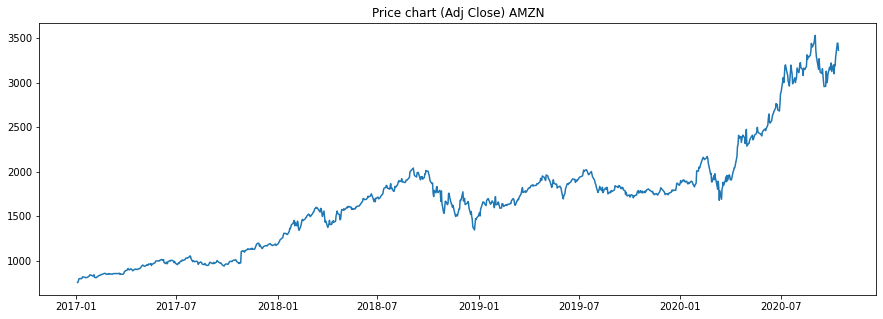

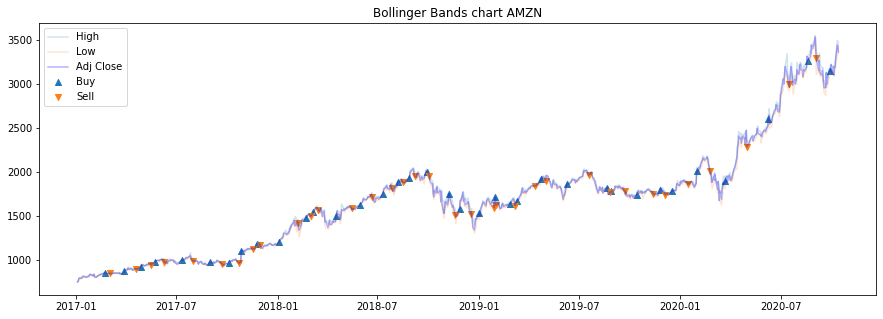

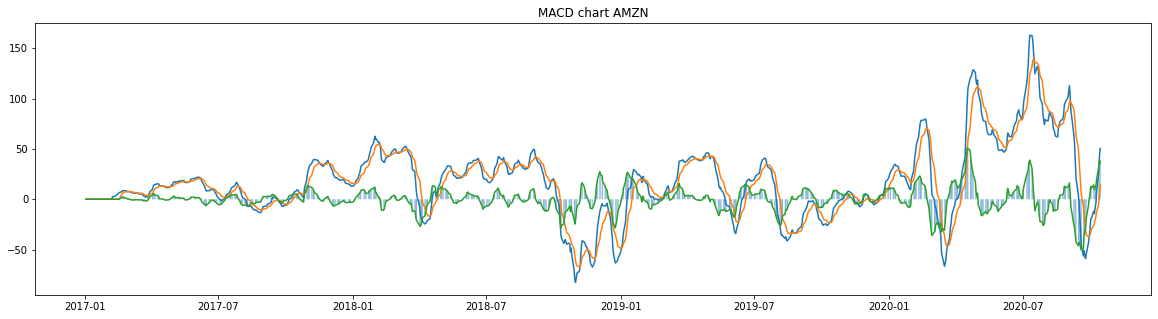

In [1328]:
plot_signals(df, ticker)

#### Modified buy/sell signalling - long only below zero line, short only above zero line

when MACD line crosses above signal line - we consider it as a buy signal. But we will impose further conditions.
We will buy only when bulish MACD crossover occurs below zero line and when we are in a bullish uptrend - price is above 200 EMA.

Well, 200 EMA is maybe too much, lets try some shorter trend - like 50 EMA or something like that.   or just 9 for removing noise - shorter trend.

Observation, if ema is 9 or higher, we might lose important signals, so shorten EMA to like 5 or keep it on like bit higher number and do extra override for crossovers too high and too low above/below zero line.


Sell setup is analogical.



In [1329]:
def get_EMA(df, n=200):
    # computes 200 EMA
    ema = df['Adj Close'].ewm(span=n, adjust=False).mean()
    df['EMA'] = ema
    
    
    return df

In [1330]:
df = get_EMA(df, 9)

In [1331]:
#modified strategy according to tradingrush
#https://www.youtube.com/watch?v=nmffSjdZbWQ&ab_channel=TRADINGRUSH


def buy_sell(signal):
    Buy = []
    Sell = []
    flag = -1
    
    for i in range(0,len(signal)):
        # BUY
        if (signal['MACD'][i] > signal['MACDsig'][i]):   # first occurence of MACD crossing above signal oine
            Sell.append(np.nan)                        # so first flip above means buy
            if (flag != 1) :                              # after first occurence i record flip to ignore
                                                       # from here onwards
                flag = 1
                
                # looking for higher magnitudes 
                if ((signal['Adj Close'][i] > signal['EMA'][i])     and   \
                    (signal['MACD'][i] < (-2) )                        and   \
                    (signal['MACD'][i] < 0)   ):
                    Buy.append(signal['Close'][i])
                elif (signal['MACD'][i] < (-3) ):   #override
                    Buy.append(signal['Close'][i])
                
                else:
                    Buy.append(np.nan) 
                
            else:
                Buy.append(np.nan)
        
        # SELL
        elif (signal['MACD'][i] < signal['MACDsig'][i]):
            
            Buy.append(np.nan)
            if (flag != 0) :
                flag = 0
                
                # looking for higher magnitudes
                if ( (signal['Adj Close'][i] < signal['EMA'][i])     and   \
                    (signal['MACD'][i] > 2)                         and    \
                    (signal['MACD'][i] > 0)   ) :
                    Sell.append(signal['Close'][i])
                elif (signal['MACD'][i] > 3 ):   #override
                    Sell.append(signal['Close'][i])    
                else:
                    Sell.append(np.nan)    
                
            else:
                Sell.append(np.nan)
        
        else:
            Buy.append(np.nan)
            Sell.append(np.nan)
            
    return (Buy, Sell)            


# create buy and sell column
a = buy_sell(df)
df['Buy_Signal_Price'] = a[0]
df['Sell_Signal_Price'] = a[1]


In [1332]:
#for i in range(len(df)):
#    print(df['Sell_Signal_Price'][i])



#df

In [1333]:
#mine implementation
def plot_signals(df, ticker):
    
    import matplotlib.gridspec as gridspec
    
    gs =  gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(30,15))   
    
    
    
    
    # plot price
    ax1 = fig.add_subplot(gs[0])

    ax1.plot(df['Date'], df['Adj Close'], label='Adj Close')
    ax1.set_title('Price chart (Adj Close) ' + str(ticker))
    ax1.legend()
    #plt.show()

    # plot  values and significant levels
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.set_title('Bollinger Bands chart ' + str(ticker))
    ax2.plot(df['Date'], df['High'], label='High', alpha=0.2)
    ax2.plot(df['Date'], df['Low'], label='Low', alpha=0.2)
    ax2.plot(df['Date'], df['Adj Close'], label='Adj Close', color='blue', alpha=0.3)

    ax2.plot(df['Date'], df['EMA'], label='EMA', color='blue', alpha=0.3)
    
    
    #plt.plot(df['Date'], df['High'], label='High', alpha=0.3)
    #plt.plot(df['Date'], df['Low'], label='Low', alpha=0.3)

    #plt.plot(df['Date'], df['BU'], label='B_Upper', alpha=0.3)
    #plt.plot(df['Date'], df['BL'], label='B_Lower', alpha=0.3)
    #plt.plot(df['Date'], df['B_MA'], label='B_SMA', alpha=0.3)
    #plt.fill_between(df['Date'], df['BU'], df['BL'], color='grey', alpha=0.1)

    ax2.scatter(df['Date'], df['Buy_Signal_Price'], label='Buy', marker='^')
    ax2.scatter(df['Date'], df['Sell_Signal_Price'], label='Sell', marker='v')

    ax2.legend()

    #plt.show()
    
    #third plot
    ax3 = fig.add_subplot(gs[2], sharex=ax2)
    
    #plt.figure(figsize=(20,5))
    ax3.set_title('MACD chart ' + str(ticker))
    ax3.plot(df['Date'], df['MACD'].fillna(0), label='MACD')
    ax3.plot(df['Date'], df['MACDsig'].fillna(0), label='MACDsig')
    ax3.plot(df['Date'], df['MACDhist'].fillna(0), label='MACDhist')
    ax3.bar(df['Date'], df['MACDhist'].fillna(0), width=0.5, snap=False, label='MACDhist')
    ax3.legend()
    
    plt.show()
    
    return None

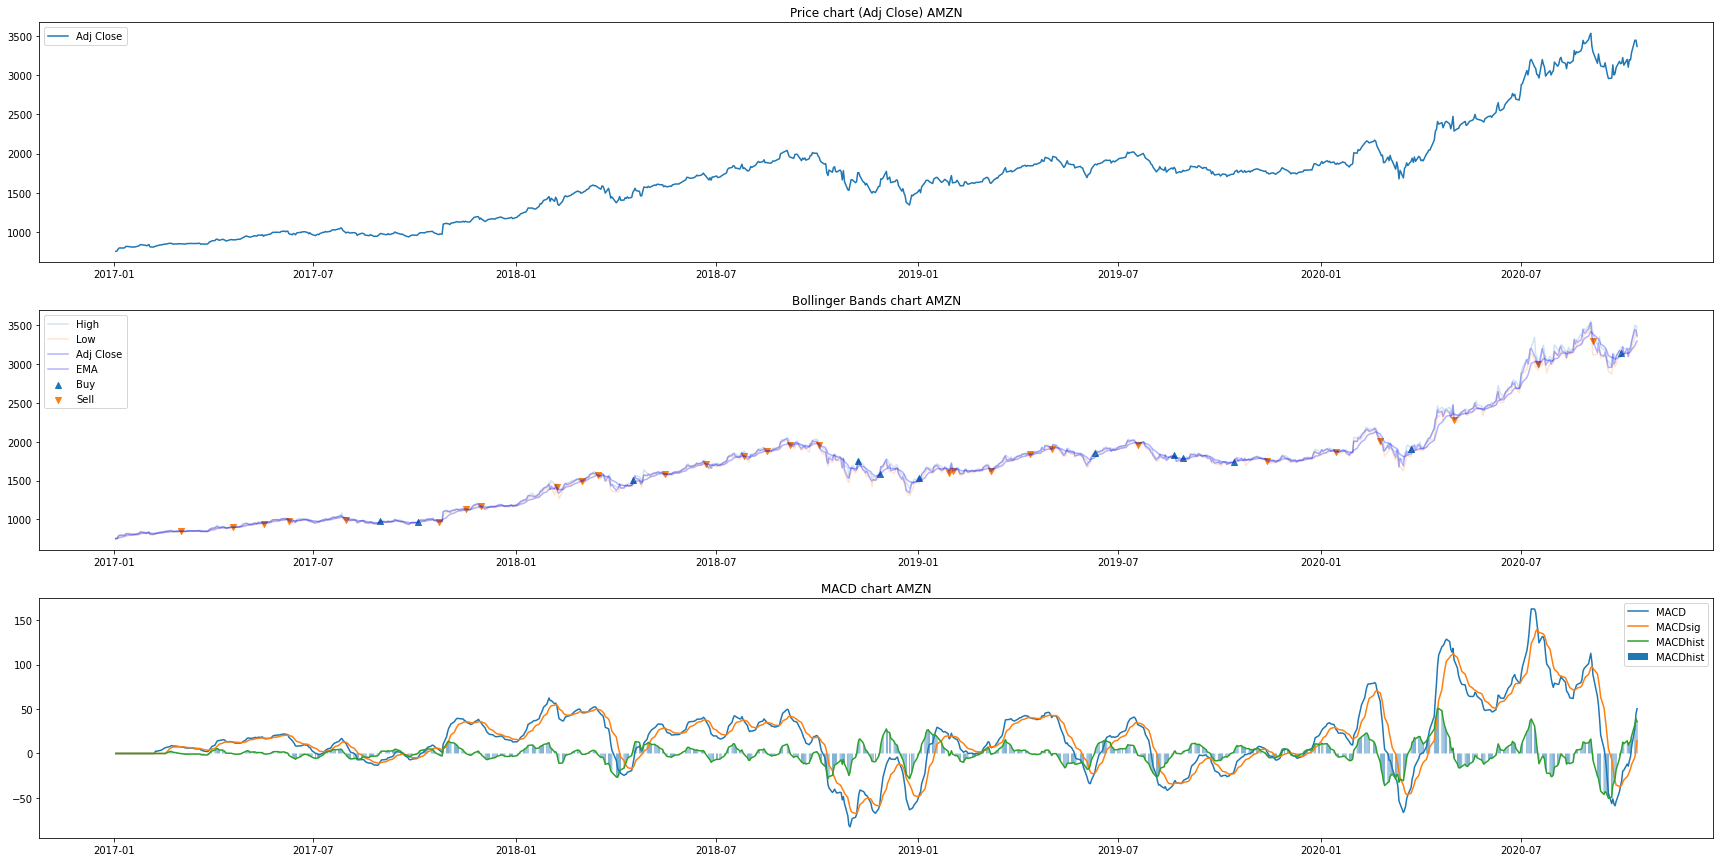

In [1334]:
plot_signals(df, ticker)

#### Sources:
https://github.com/Crypto-toolbox/pandas-technical-indicators  <BR>
https://www.quantopian.com/posts/technical-analysis-indicators-without-talib-code  <BR>
https://www.investopedia.com/terms/m/macd.asp  <BR>    
https://www.youtube.com/watch?v=qyU9IM3M_Kw&ab_channel=EXFINSISExpertFinancialAnalysis   <BR> 
https://www.youtube.com/watch?v=E3KP1WyLITY&ab_channel=Trading212    <BR>
https://www.youtube.com/watch?v=kz_NJERCgm8&t=493s&ab_channel=ComputerScience  <BR>
    
    
https://www.youtube.com/watch?v=RzGIdibpo8Q&ab_channel=TRADINGRUSH    <BR>
https://www.youtube.com/watch?v=nmffSjdZbWQ&ab_channel=TRADINGRUSH    <BR>    

https://stackoverflow.com/questions/31810461/python-matplotlib-vertically-aligned-plots-in-matplotlib    
    
    